In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run stochastic_lstm_optimizer.py

In [3]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', **kwargs):
        n_steps = T.iscalar()
        
        l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
        self.l_optim = LSTMOptimizerLayer(l_input, n_steps=n_steps, function=func, **kwargs)
        
        self.params_init = L.layers.get_all_param_values(self.l_optim)

        theta_history, loss_history = L.layers.get_output(self.l_optim)
        if loss_type == 'sum':
            loss = loss_history.sum()
        else:
            loss = np.log(loss_history).sum()
        
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.l_optim, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                loss = sum(loss_history)
                training_loss_history.append(loss_history)

            display.clear_output(wait=True)
            plt.semilogy(np.median(training_loss_history, axis=0))
            plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [4]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum()
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [5]:
W = T.matrix()
b = T.vector()
    
func = lambda theta: QuadraticFunction(theta, W, b).func

In [6]:
input_var = T.vector()

In [7]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [8]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [9]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
}

for n_gac in [0, 5]:
    for loss_type in ['sum', 'prod']:
        options['n_gac'] = n_gac
        options['loss_type'] = loss_type
        
        key = "n_gac={}; loss_type={}".format(n_gac, loss_type)
        lstm_optimizers[key] = LSTMOptimizer(input_var, func, [W, b], **options)

In [10]:
def sample_params(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.random.randn(ndim, ndim))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point(ndim):
    theta = np.cast['float32'](np.random.randn(ndim))
    return theta

def sample_point_and_params(ndim=None):
    W, b = sample_params(ndim)
    theta = sample_point(len(b))
    
    return theta, (W, b)

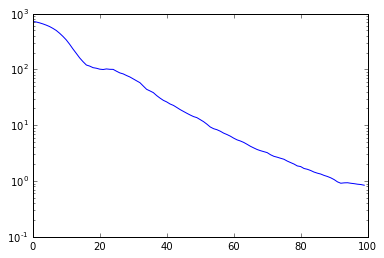

Epoch number 49
Time on epoch 49: 88.92859888076782
Loss on 49: 856.0443934202194; 0.8395423293113708


In [ ]:
training_options = {
    'n_iter': 100,
    'n_epochs': 50,
    'batch_size': 100,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    opt.train(sample_point_and_params, **training_options)

In [12]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [15]:
def test_optimizers(**testing_options):
    thetas_and_params = [sample_point_and_params() for _ in range(testing_options['n_functions'])]
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
        plt.semilogy(np.median(loss_history, axis=0), label='lstm; {}'.format(key))

    #lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    lrates = [0.008192]
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        plt.semilogy(best_history, label="{name}; lr={best_lrate}".format(**locals()), linestyle='--')

    plt.legend()
    plt.show()

Testing lstm; n_gac=0; loss_type=prod
Testing lstm; n_gac=5; loss_type=prod
Testing lstm; n_gac=5; loss_type=sum
Testing lstm; n_gac=0; loss_type=sum
Testing momentum


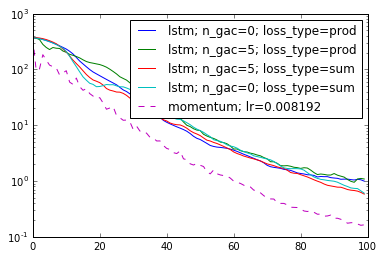

In [20]:
testing_options = {
    'n_iter': 100,
    'n_functions': 100,
}

test_optimizers(**testing_options)

In [17]:
theta, (W_, b_) = sample_point_and_params(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)

sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 0.008192)
    
# for name, opt in non_lstm_optimizers.items():
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#             history, losses = opt(theta, 300, W_, b_, lrate)
#             history = [theta] + history

#             sample_runs["{}; lr={}".format(name, lrate)] = (history, losses)

[ 3.88086367  1.59242177]


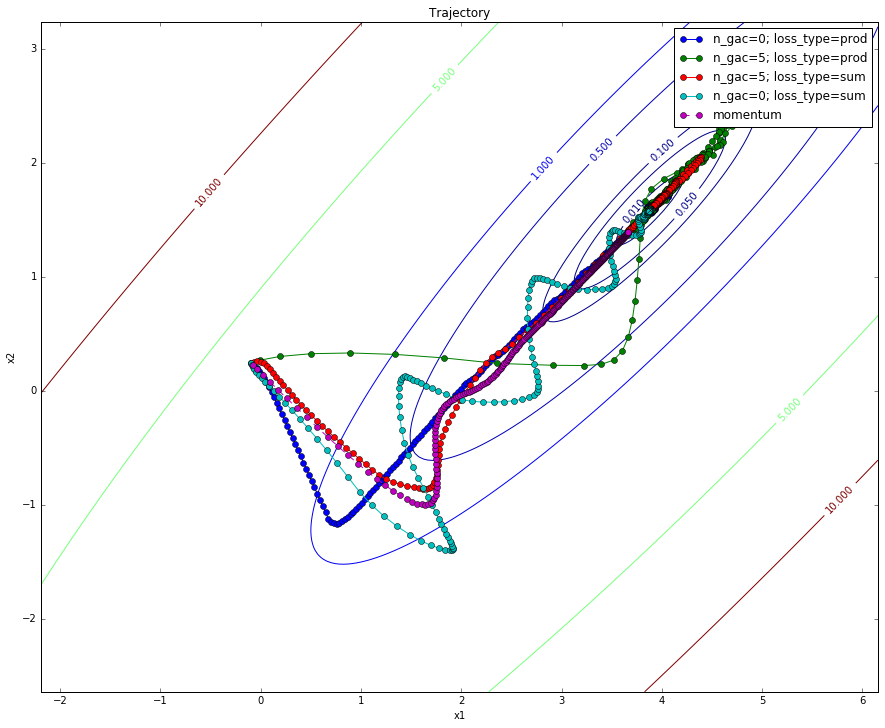

In [18]:
theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
# x = np.arange(min_x, max_x, delta_x)
# y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

#Z = ((W.dot(X) - b_)**2).sum()

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in lstm_optimizers:
    history, _ = sample_runs[name]
    plt.plot(history.T[0], history.T[1], marker='o', label=name)

history, _ = sample_runs['momentum']
plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#         #if 1e-4 < lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             history, _ = sample_runs[key]
#             plt.plot(np.array(history).T[0], np.array(history).T[1], label=key, marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

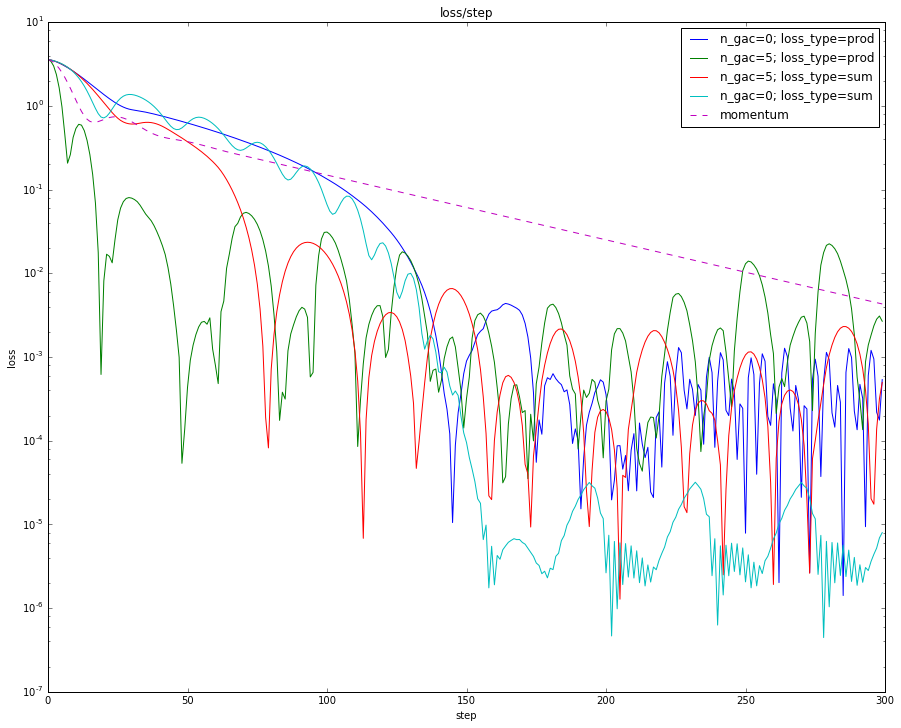

In [19]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in lstm_optimizers:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name)

_, losses = sample_runs['momentum']    
plt.semilogy(losses, label='momentum', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008912:
#         #if lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             _, losses = sample_runs[key]
#             plt.semilogy(losses, label=key, linestyle='--')
plt.legend();

In [ ]:
# generalization_loss_lstm = {name: [] for name in lstm_optimizers}

for n_c in range(2, 150):
    print(n_c)
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for _ in range(10):
            theta, (W_, b_) = sample_point_and_params(ndim=n_c)    
            loss = 1. / n_c * opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm[name].append(np.mean(losses))

In [ ]:
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(range(2, 75), losses, label=name)
plt.legend(loc=4);

In [21]:
for name, opt in lstm_optimizers.items():
    np.savez('2layer_optimizer_({}).npz'.format(name), L.layers.get_all_param_values(opt.l_optim))